# This project will build a model to automatically classify 100 plant species using features extracted from their leaf images.

In [194]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_highcharts.display import display_charts
from skimage import feature, io
from skimage.transform import rescale
from sklearn.manifold import MDS
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

### There are pre-extracted plant features stored in three files.

In [36]:
#A function to read the files and show basic information.
f_loc = 'species100/'
def file_input(file,prefix,n_cols):
    df = pd.read_csv(f_loc+file, header=None, names=[prefix+str(i) for i in range(n_cols)])
    print('(rows, columns): ',df.shape)
    print(df.head(2))
    print('Amount of Null Values: ',df.isnull().sum().sum())
    return df

In [37]:
#read the files
df_sha = file_input('data_Sha_64.txt','sha',65)

(rows, columns):  (1600, 65)
              sha0      sha1      sha2      sha3      sha4      sha5  \
0  Acer Capillipes  0.000579  0.000609  0.000551  0.000554  0.000603   
1  Acer Capillipes  0.000630  0.000661  0.000719  0.000651  0.000643   

       sha6      sha7      sha8      sha9    ...        sha55     sha56  \
0  0.000614  0.000611  0.000611  0.000611    ...     0.000507  0.000533   
1  0.000640  0.000646  0.000624  0.000584    ...     0.000503  0.000520   

      sha57     sha58     sha59     sha60     sha61     sha62     sha63  \
0  0.000555  0.000565  0.000581  0.000597  0.000625  0.000624  0.000617   
1  0.000533  0.000564  0.000596  0.000623  0.000642  0.000661  0.000671   

      sha64  
0  0.000614  
1  0.000667  

[2 rows x 65 columns]
Amount of Null Values:  0


In [38]:
df_mar = file_input('data_Mar_64.txt','mar',65)

(rows, columns):  (1600, 65)
             mar0      mar1      mar2      mar3      mar4      mar5      mar6  \
0  Acer Campestre  0.003906  0.003906  0.027344  0.033203  0.007812  0.017578   
1  Acer Campestre  0.005859  0.013672  0.027344  0.025391  0.013672  0.029297   

       mar7      mar8      mar9  ...       mar55  mar56     mar57     mar58  \
0  0.023438  0.005859  0.000000  ...    0.011719    0.0  0.005859  0.035156   
1  0.019531  0.000000  0.001953  ...    0.017578    0.0  0.021484  0.017578   

      mar59     mar60     mar61     mar62     mar63  mar64  
0  0.027344  0.033203  0.001953  0.000000  0.017578    0.0  
1  0.046875  0.005859  0.003906  0.003906  0.046875    0.0  

[2 rows x 65 columns]
Amount of Null Values:  0


In [39]:
df_tex = file_input('data_Tex_64.txt','tex',65)

(rows, columns):  (1599, 65)
             tex0      tex1      tex2      tex3      tex4      tex5  tex6  \
0  Acer Campestre  0.025391  0.012695  0.003906  0.004883  0.039062   0.0   
1  Acer Campestre  0.004883  0.018555  0.002930  0.000000  0.069336   0.0   

       tex7      tex8      tex9    ...        tex55  tex56     tex57  \
0  0.017578  0.035156  0.023438    ...     0.103520    0.0  0.001953   
1  0.013672  0.043945  0.026367    ...     0.070312    0.0  0.017578   

      tex58     tex59  tex60  tex61     tex62  tex63     tex64  
0  0.000977  0.022461    0.0    0.0  0.001953    0.0  0.027344  
1  0.000000  0.004883    0.0    0.0  0.000000    0.0  0.002930  

[2 rows x 65 columns]
Amount of Null Values:  0


### The texture file is one row less than the other two files.

In [40]:
# A function to compare the speices names between the different datasets.
def comp(list_of_datasets):
    comp = pd.DataFrame()
    for df in list_of_datasets:
        comp[df.columns[0]] = df[df.columns[0]].unique()
    diff = comp[comp.apply(lambda x: len(set(x)) != 1, axis=1)]
    print('Different names: ',len(diff))
    print(diff.head(10))

In [41]:
#compare the names.
df_list = [df_sha, df_mar, df_tex]
comp(df_list)

Different names:  99
                    sha0             mar0             tex0
0        Acer Capillipes   Acer Campestre   Acer Campestre
1            Acer Opalus  Acer Capillipes  Acer Capillipes
2            Acer Pictum  Acer Circinatum  Acer Circinatum
3     Alnus Maximowiczii        Acer Mono        Acer Mono
4      Cotinus Coggygria      Acer Opalus      Acer Opalus
5  Populus Grandidentata    Acer Palmatum    Acer Palmatum
6    Arundinaria Simonii      Acer Pictum      Acer Pictum
7   Callicarpa Bodinieri  Acer Platanoids  Acer Platanoids
8      Celtis Koraiensis      Acer Rubrum      Acer Rubrum
9    Cercis Siliquastrum   Acer Rufinerve   Acer Rufinerve


### There are a lot of differences probably because the names are not alphabetically ordered.

In [44]:
# Sort the name columns
for df in df_list:
    df.sort_values(by=[df.columns[0]], axis=0, ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

#compare the datasets again.
comp(df_list)

Different names:  0
Empty DataFrame
Columns: [sha0, mar0, tex0]
Index: []


### The datasets contain the same 100 plant species. One species in the texture dataset probably has one sample missing. Each species should have 16 samples. 

In [48]:
#Find the minimun number of samples for all species in the texture file.
df_tex.groupby(['tex0'])['tex1'].count().min()

15

In [49]:
#Find out the species that has one sample missing.
df_tex.groupby(['tex0'])['tex1'].count().argmin()

'Acer Campestre'

### I can either fill one row in the texture file or delete one row from the other two files, if I want to combine them. Filling one row is probably better. This would also make data plotting easier. 

In [62]:
#Create a one-row dataframe with NaN values and add it onto df_dex.
fill = pd.DataFrame(index=[0],columns=[df_tex.columns])
df_texf = fill.append(df_tex,ignore_index=True)

In [65]:
df_texf.head(2)

,tex0,tex1,tex2,tex3,tex4,tex5,tex6,tex7,tex8,tex9,...,tex55,tex56,tex57,tex58,tex59,tex60,tex61,tex62,tex63,tex64
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Acer Campestre,0.025391,0.012695,0.003906,0.004883,0.039062,0.0,0.017578,0.035156,0.023438,...,0.10352,0.0,0.001953,0.000977,0.022461,0.0,0.0,0.001953,0.0,0.027344


In [87]:
#Fill in the name.
df_texf.ix[0,'tex0'] = 'Acer Campestre'

#Fill in the mean values of the 15 Acer Campestre samples
for i in range(1,65):
    df_texf.ix[0,'tex'+str(i)] = df_texf.ix[1:15, 'tex'+str(i)].mean()

print('Amnount of null values: ',df_texf.isnull().sum().sum())
print('(rows, columns): ',df_texf.shape)

Amnount of null values:  0
(rows, columns):  (1600, 65)


### Dimension reduction for plotting.

In [68]:
#Use MDS to reduce 64 feature vectors to 2.
mds = MDS(n_components=2, metric=True, 
          n_init=4, max_iter=300, verbose=0, 
          eps=0.001, n_jobs=1, random_state=None, 
          dissimilarity='euclidean')

In [73]:
#Dimension reduction for the datasets.
shape_2d = mds.fit_transform(df_sha.ix[:, 'sha1':'sha64'])
margin_2d = mds.fit_transform(df_mar.ix[:, 'mar1':'mar64'])
texture_2d = mds.fit_transform(df_tex.ix[:, 'tex1':'tex64'])
texture_f2d = mds.fit_transform(df_texf.ix[:, 'tex1':'tex64'])

In [74]:
#Create dataframes for plotting analysis. 
#For the texture data analysis, I will only use the refilled dataset.
sha_plot = df_sha[['sha0']].join(pd.DataFrame(shape_2d, columns=['Shape X','Shape Y']))
mar_plot = df_mar[['mar0']].join(pd.DataFrame(margin_2d, columns=['Margin X','Margin Y']))
texf_plot = df_texf[['tex0']].join(pd.DataFrame(texture_f2d, columns=['Texture X','Texture Y']))
tex_plot = df_tex[['tex0']].join(pd.DataFrame(texture_2d, columns=['Texture X','Texture Y']))

In [75]:
sha_plot.head(2)

,sha0,Shape X,Shape Y
0,Acer Campestre,-0.000626,-0.001758
1,Acer Campestre,-0.000386,0.000184


### Plot the 2-dimension features to see if the plants cluster and can be potentiall seperated from each other.


In [140]:
#Customize a color list.
color_list = ['firebrick','darkorange','darkviolet','royalblue','forestgreen',
          'magenta','aquamarine','palegreen','yellow','grey']

In [147]:
#A function to plot 2-d features in scatter for 10 species in each panel.
def feature_plot(df, n_split):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(25,9))
    for ax, i in zip(axes.flat, range(160,160*11,160)):
        n = 0
        groups = df.ix[i-160:i-1,:].groupby([df.columns[0]])
        for name, g in groups:
            name = name.split(n_split)
            name = name[0][0] + '. ' + name[-1][:3].lower()
            ax.scatter(g[df.columns[1]], g[df.columns[2]], 
                       label=name, s=30, c=color_list[n])
            n = n + 1
        
        ax.legend(loc='best', prop={'size':10}, frameon=False)

    plt.suptitle(df.columns[1]+' '+df.columns[2], fontsize=26)

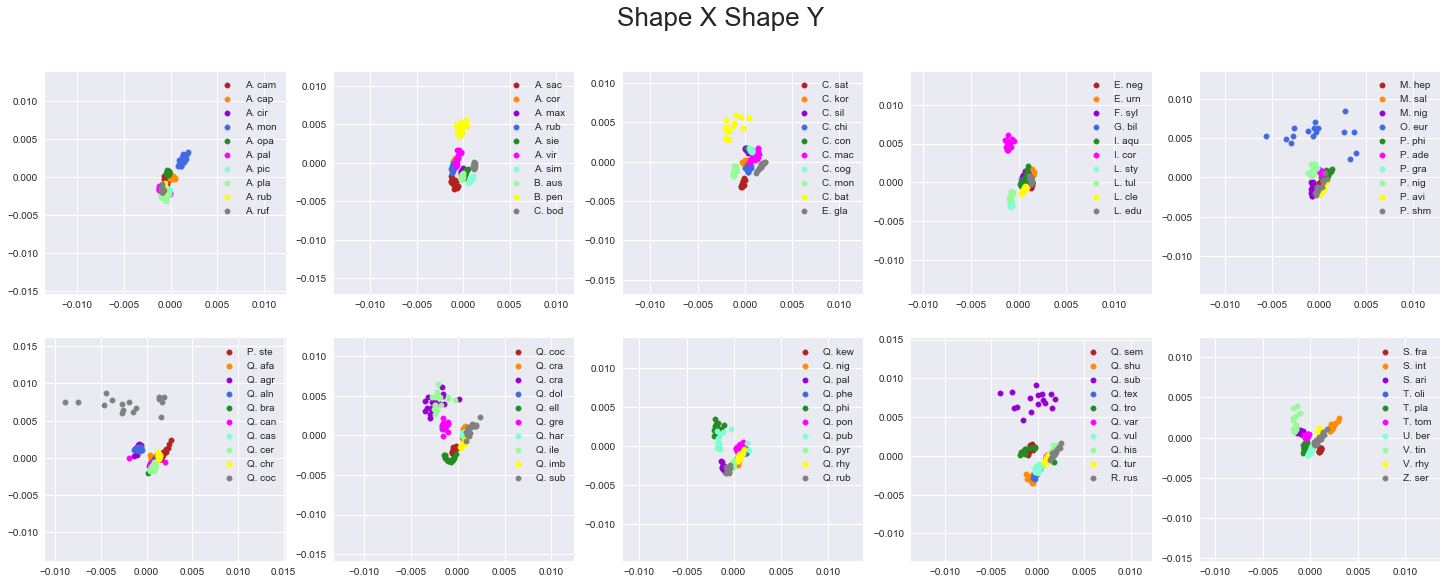

In [148]:
feature_plot(sha_plot, ' ')
plt.show()
plt.close()

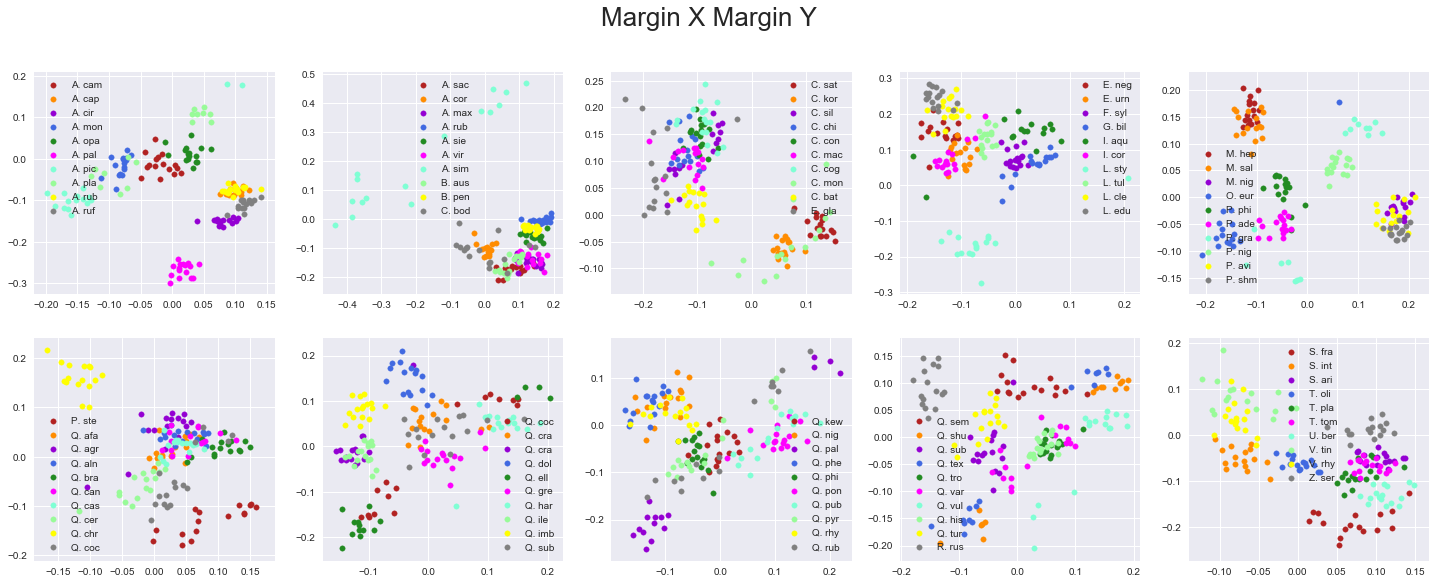

In [149]:
feature_plot(mar_plot, ' ')
plt.show()
plt.close()

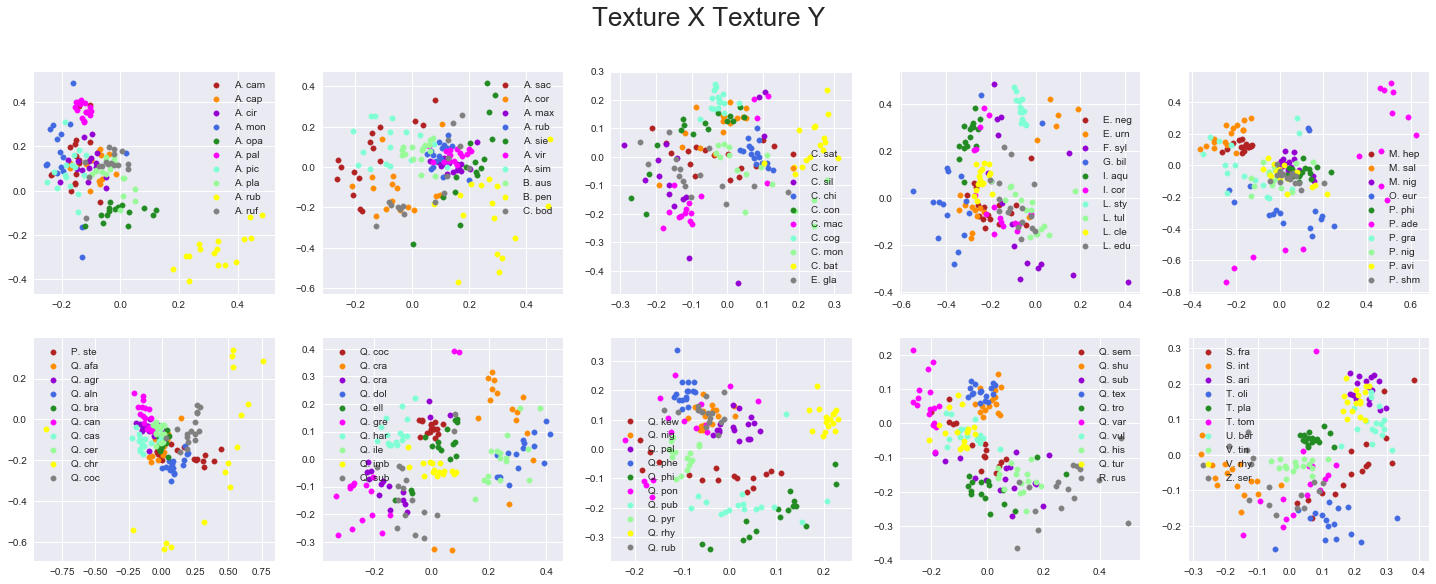

In [150]:
feature_plot(texf_plot, ' ')
plt.show()
plt.close()

### The plant species cluster well by the shape features, while they are more spread out by margin and texture features. The reasonable seperation of the species in the 2 D space suggests that the three pre-extracted features are likely very useful for building algorithms to automatically classify plants. 
### It however may be still difficult to combine three features for classification because the 16 samples of each species are not ordered in the same way between the different feature datasets.

### Use pandas-highcharts to visulize the orginal feature vectors.

In [152]:
#Visulize the mean values of the shape feature vectors of the first 10 species.
display_charts(df_sha.ix[0:159,:].groupby(by=['sha0']).mean(), 
               title="Mean Values of Shape Feature Vectors",
               kind='bar')

In [156]:
#Visulize the mean values of the margin feature vectors of the first 10 species.
display_charts(df_mar.ix[0:159,:].groupby(by=['mar0']).mean(), 
               title="Mean Values of Margin Feature Vectors",
               kind='bar')

In [155]:
#Visulize the mean values of the texture feature vectors of the first 10 species.
display_charts(df_texf.ix[0:159,:].groupby(by=['tex0']).mean(), 
               title="Mean Values of Texture Feature Vectors",
               kind='bar')

### The highcharts suggest that some species have signiture values of the feature vectors. For example, Acer mono is distinct in the shape feature vactors, Acer palmatum is distinct in the margin feature vectors and Acer rubrum is distinct in the texture feature vectors. These species are indeed well seperated in the 2-D feature plots (the first panels).

-----

### To extract features from the original images. There are 16 images for each species and there are 100 species.

### Display the first image for each species.

In [184]:
#Collect the folders of the images.
data_root = './species100/data/'
all_list = os.listdir(data_root)
folders = []
for item in all_list:
    if os.path.isdir(data_root+item):
        folders.append(item)

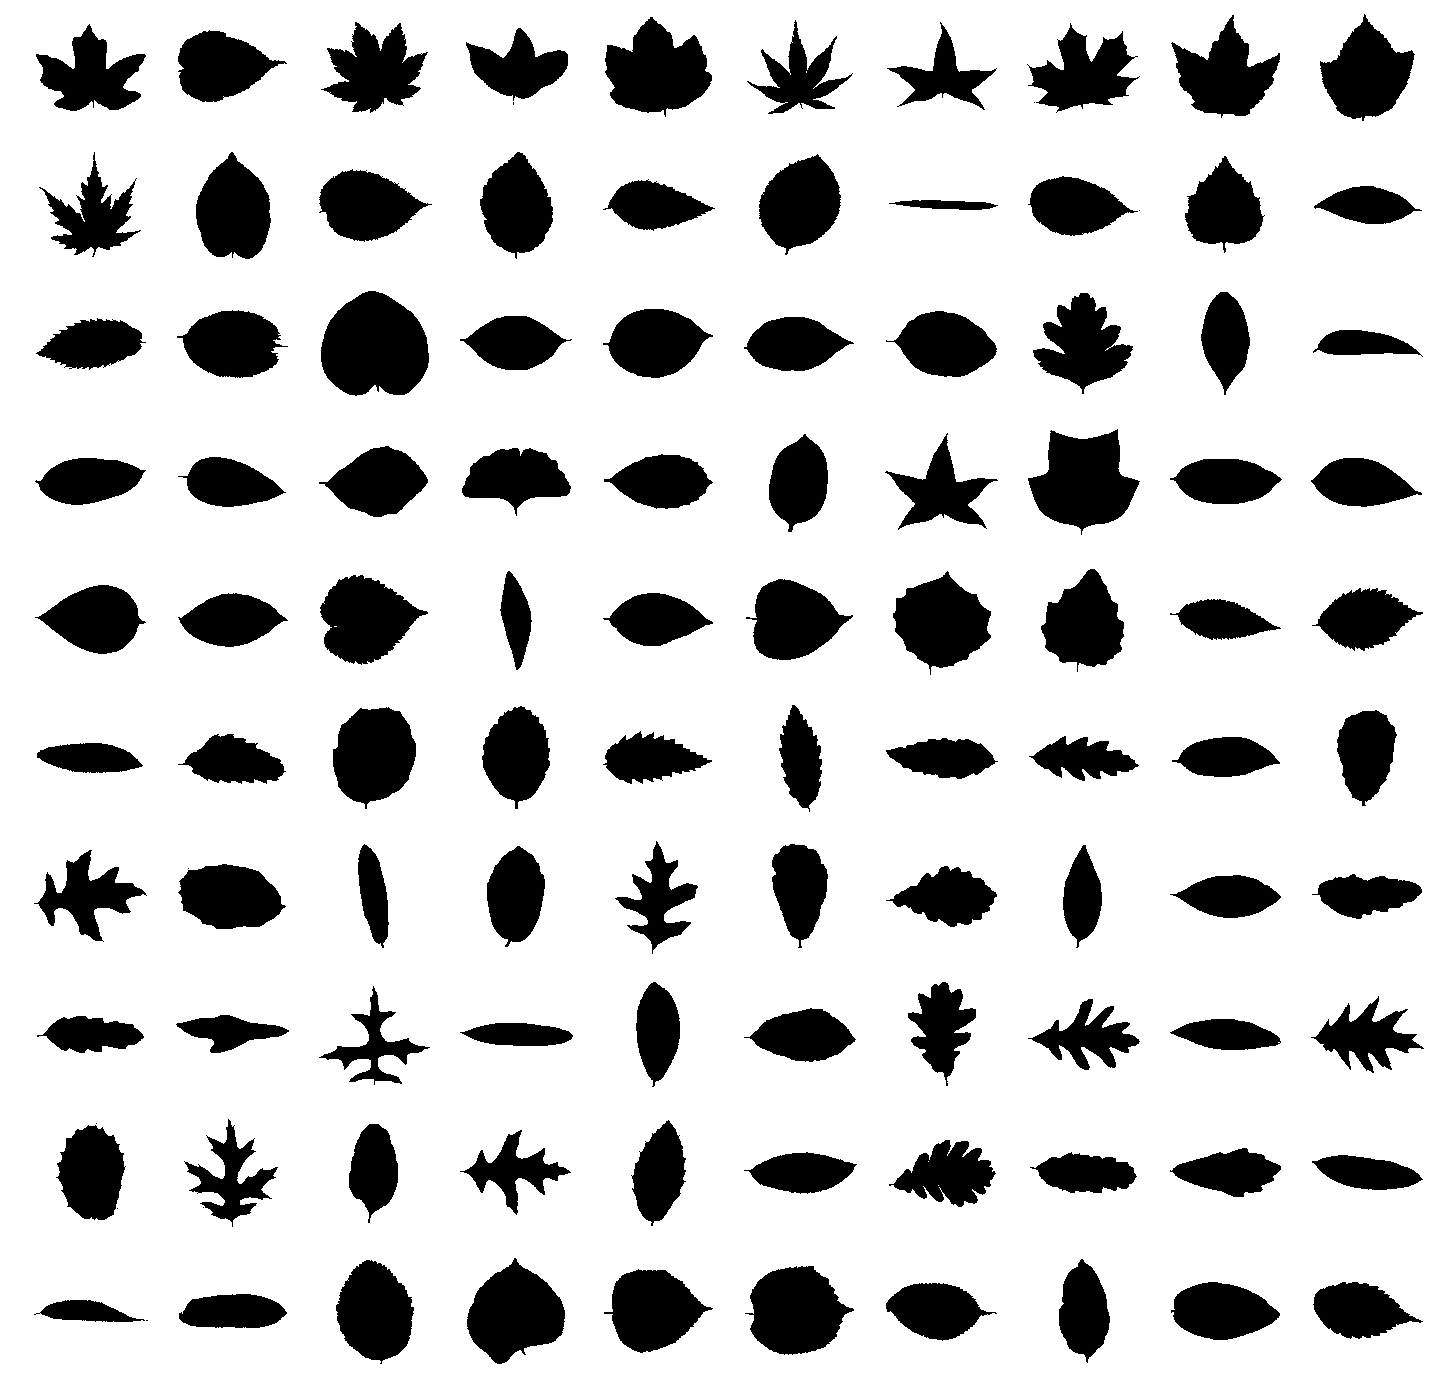

<function matplotlib.pyplot.close>

In [187]:
# Plot the images.
fig, axes = plt.subplots(nrows=10, ncols=10, sharex=False, sharey=False, figsize=(25,25))
for d, ax in zip(folders, axes.flat):
    img = io.imread(data_root+d+'/'+d+'_01.ab.jpg')
    ax.imshow(img)
    ax.grid('off')
    ax.axis('off')
plt.show()
plt.close

### Rescale the images to smaller sizes so that work can be done on my laptop.

In [200]:
#Create a directory for rescaled images.
smalldata_root = './species100/data_small/'
if os.path.exists(smalldata_root):
    pass
else:
    os.mkdir(smalldata_root)

In [201]:
#Create sub directories for rescaled images.
for d in folders:
    if os.path.exists(smalldata_root+d):
        pass
    else:
        os.mkdir(smalldata_root+d)

In [ ]:
#Rescale the images and save them in new folders
for d in folders:
    all_files = os.listdir(data_root+d)
    jpg_files = []
    for f in all_files:
        if '.jpg' in f:
            jpg_files.append(f)
    for jpg_f in jpg_files:
        img_ori = io.imread(data_root+d+'/'+jpg_f)
        img_small = rescale(img_ori, 0.15)
        io.imsave(smalldata_root+d+'/'+jpg_f, img_small)

### Use an original image to test feature extraction.

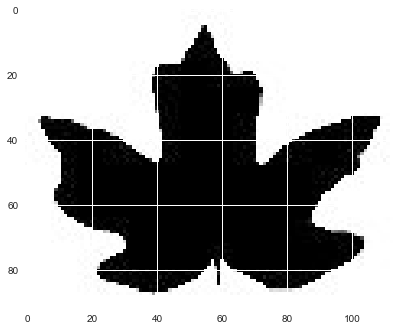

In [213]:
#Display the small image
testim = io.imread(smalldata_root+'Acer_Campestre/Acer_Campestre_01.ab.jpg')
plt.imshow(testim)
plt.show()
plt.close()

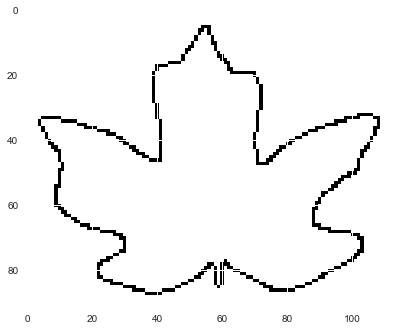

In [223]:
# Test parameters for extraction of canny edges.
cann_edge = feature.canny(testim, sigma=1.0, 
                          low_threshold=None, high_threshold=None, 
                          mask=None, use_quantiles=False)
plt.imshow(cann_edge)
plt.show()
plt.close()

### Extract canny edges for all small images.

In [230]:
#collect the small image folders
all_content = os.listdir(smalldata_root)
small_folders = []
for item in all_content:
    if os.path.isdir(smalldata_root+item):
        small_folders.append(item)

In [304]:
#Create an empty feature list.
cann_edge = []
#Collect jpg files in folders and extract canny edge features
for d in small_folders:
    all_things = os.listdir(smalldata_root+d)
    jpg_only = []
    for f in all_things:
        if '.jpg' in f:
            jpg_only.append(f)
    for jpg_f in jpg_only:
        small_image = io.imread(smalldata_root+d+'/'+jpg_f)
        edge_feature = feature.canny(small_image, sigma=1.0, 
                                     low_threshold=None, high_threshold=None, 
                                     mask=None, use_quantiles=False)
        cann_edge.append(np.append([d], edge_feature.astype(int).flat))

In [318]:
df_cedge = pd.DataFrame(cann_edge, dtype=float, columns=['cedge'+str(i) for i in range(31258)])
df_cedge.shape

(1600, 31258)

In [319]:
df_cedge.head(2)

,cedge0,cedge1,cedge2,cedge3,cedge4,cedge5,cedge6,cedge7,cedge8,cedge9,...,cedge31248,cedge31249,cedge31250,cedge31251,cedge31252,cedge31253,cedge31254,cedge31255,cedge31256,cedge31257
0,Acer_Campestre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Acer_Campestre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### There are a lot of "None" because the images are different in size. Fill in 0 for the "None" values and make a new dataframe for plotting.

In [280]:
df_cedge.fillna(float(0.0), inplace=True)
df_cedge.isnull().sum().sum()

0

In [282]:
#Dimension reduction for the datasets.
cedge_2d = mds.fit_transform(df_cedge.ix[:, 'cedge1':'cedge31257'])

In [283]:
#Create dataframes for plotting analysis. 
cedge_plot = df_cedge[['cedge0']].join(pd.DataFrame(cedge_2d, columns=['Canny Edge X','Canny Edge Y']))

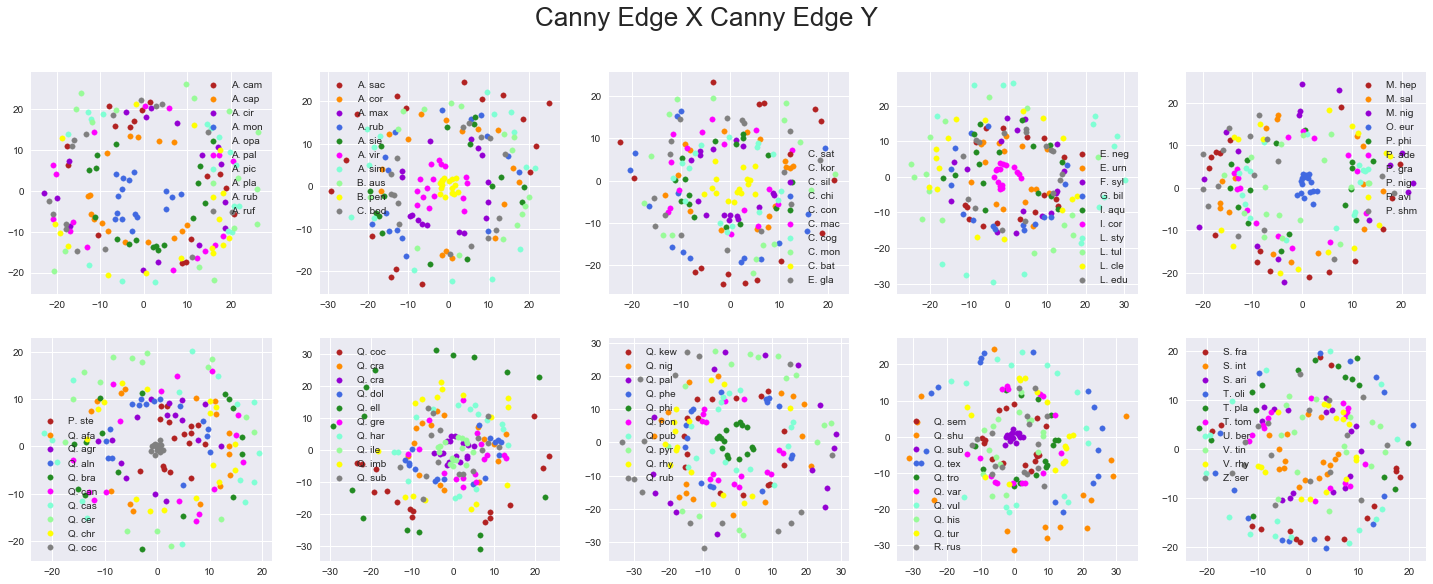

In [284]:
#Plotting the 2-D edge features.
feature_plot(cedge_plot, '_')
plt.show()
plt.close()

### The species seem to be distributed in ring like patterns. They seem to be reasonably seperated by the 2-D canny edge features.  

### I will try to extract other features if this is good.